In [1]:
import numpy as np
import scipy.special
import matplotlib.pyplot as plt

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['figure.subplot.bottom'] = 0.2
plt.rcParams['figure.subplot.left'] = 0.2

def axNormal(ax):
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')

gamma = 1.4
R = 8.314462
MW_g = (28 * 0.8 + 32 * 0.2) * 1e-3  # Molecular weight


## General drag coefficient (Singh, 2020)
Inputs for this function are: **Mach number**, **Reynolds number**, **Fluid temperature**  
Return is **Drag coefficient**  
  
*Notes*  
* Particle temperature is identical to fluid temperature  
* Fluid is only air  

### Equaiton

$$
\begin{gather*}
C_{\rm{D}} = C_{\rm{d,C}} \frac{f_{Kn}}{1+Br^{\eta}} + C_{\rm{d,FM}} \frac{Br^{\eta}}{1+Br^{\eta}}\\

C_{\rm{d,C}}=C_1(1-\alpha U^*)+C_0 {C_2}^2 \Theta\\
C_1=\frac{
        0.9-C_0\left[ 1+\frac{\gamma^2}{4\gamma} \right]^\frac{\gamma}{\gamma-1}
    }{1-\frac{\gamma-1}{\alpha _0 M (\gamma +1)}}\\
\alpha=\frac{1}{\alpha _0 M + 1 + \alpha _0}\\

C_0=\frac{24}{{\delta _0}^2}\\
C_2=1+\frac{\delta _0}{Re^*}\\
Re^*=Re \left[ \frac{1}{\alpha^2 T^*} \right]^{\omega} \Theta^{\frac{\gamma+1}{2\gamma}-\frac{\omega(\gamma-1)}{\gamma}}\\
\Theta=\left[ 1+\frac{(\gamma-1){M_{\rm{s}}}^2}{2} \right]^{\frac{\gamma}{\gamma-1}}\\
U^*=\frac{U_{\rm{s}}}{U}=\frac{s_1}{(\gamma+1)M^2}\\
T^*=\frac{T_{\rm{s}}}{T}=\frac{s_1 s_2}{(\gamma+1)^2 M^2}\\
M_{\rm{s}}=\sqrt{\frac{s_1}{s_2}}\\
s_1=2+(\gamma-1)M^2\\
s_2=2 \gamma M^2 - (\gamma-1)\\

f_{Kn}=\frac{1}{
    Cc\left[
        1+\alpha _{hoc} Wr \left(
            1+\frac{1}{T^{*}}
            \right)^{\omega}
        \right]
    }\\
Wr=\frac{M^{2\omega}}{Re}\\
Cc=1+Kn\left[2.514+0.8\exp{\frac{-0.55}{Kn}}\right]\\
Kn=\frac{M}{Re}\sqrt{\frac{\gamma \pi}{2}}\\
Br=Wr\left(1+\frac{1}{T^{*}}\right)^{\omega}
    \frac{M^{2\omega -1}+1}{M^{2\omega -1}}\\

C_{\rm{d,FM}}=\frac{\pi (1 + 2s^2)\exp(-s^2)}{s^3}
+\frac{(4s^4+4s^2-1){\rm{erf}}(s)}{2s^4}
+\frac{2\sqrt{\pi}}{3s}\\
s=M\sqrt{\frac{\gamma}{2}}\\
\end{gather*}
$$

## Constant(?)
$\alpha _0=0.3555$, $\alpha _{hoc}=0.9071$, $\delta _0=9.4$, $\eta = 1.8$, and $\omega=0.74$

In [41]:
def SinghDrag(Mach, Re_d, T_g):
    T_d = T_g
    delta_o = 9.4
    Co = 24.0 / delta_o**2
    alpha_o = 0.3555
    alpha_hoc = 0.9071
    omega = 0.74 # FOR AIR - CHECK THIS

    # Subsonic case
    if (Mach <= 1):
        Ts_T = 1
        Us_U = 1
        Ms = Mach
        alpha = 1
        C1 = 1

    # Supersonic case
    gm1 = gamma - 1.0
    gp1 = gamma + 1.0
    if (Mach >= 1):
        M2 = Mach * Mach
        s_C1 = 2.0 + gm1 * M2
        s_C2 = 2 * gamma * M2 - gm1
        Us_U = s_C1 / (gp1 * M2)
        Ts_T = s_C1 * s_C2 / (gp1 * gp1 * M2)
        Ms = np.sqrt(s_C1/s_C2)
        alpha = 1.0 / (alpha_o * Mach + 1.0 - alpha_o)
        C1C1 = 0.9 - Co * np.power(1.0 + gm1 * gm1 * 0.25 / gamma, gamma / gm1)
        C1C2 = gm1 / alpha_o / gp1
        C1 = C1C1 / (1 - C1C2 / Mach)
                
    Kn = Mach / Re_d * np.sqrt(gamma * np.pi / 2.0)
    Cc = 1.0 + Kn*(2.514 + 0.8*np.exp(-0.55/Kn))
    Wr =pow(Mach, 2 * omega) / Re_d
    WrT = Wr * np.power(1.0 + 1.0 / Ts_T, omega)
    Mpow_TOMO = np.power(Mach, 2 * omega - 1)
    Br = WrT * (Mpow_TOMO + 1) / Mpow_TOMO
    fKnWr_inv = Cc * (1 + alpha_hoc * WrT)
    fKnWr = 1 / fKnWr_inv

    s = np.sqrt(gamma * 0.5) * Mach
    s2 = s * s
    s3 = s2 * s
    s4 = s2 * s2
    Cd_FM = (1.0 + 2.0*s2)*np.exp(-s2) / s3 * np.sqrt(np.pi)
    Cd_FM += (4.0*s4+4.0*s2-1.0)*scipy.special.erf(s)/(2*s4)
    Cd_FM +=  2.0/(3.0*s)*np.sqrt(np.pi*T_d/T_g)

    Theta = np.power(1.0 + gm1 * Ms * Ms / 2.0, gamma / gm1)
    Re_tilde = Re_d * np.power(1.0 / (alpha * alpha * Ts_T), omega) * np.power(Theta, gp1/(2.0*gamma) - gm1 * omega/gamma)
    C2 = 1 + delta_o / np.sqrt(Re_tilde)
    Cdc = C1 * (1 - alpha * Us_U) + Co * Theta * C2 * C2

    ita = 1.8
    Brita = np.power(Br, ita)
    C_D_singh = Cd_FM * Brita / (1.0 + Brita) + Cdc * fKnWr / (1.0 + Brita)

    return C_D_singh

## Stokes-Millikan
Inputs for this function are: **Mach number**, **Reynolds number**, **Fluid temperature**  
Return is **Drag coefficient**  
  
*Notes*  
* Fluid is only air
* $Re<0.1$

### Equation
$$
\begin{gather*}
C_{D}=\frac{24}{CcRe}\\
Cc=1+Kn\left[2.514+0.8\exp{\frac{-0.55}{Kn}}\right]\\
Kn=\frac{M}{Re}\sqrt{\frac{\gamma \pi}{2}}
\end{gather*}
$$

In [36]:
def SMDrag(Mach, Re_d):
    Kn = Mach / Re_d * np.sqrt(gamma * np.pi / 2.0)
    Cc = 1.0 + Kn*(2.514 + 0.8*np.exp(-0.55/Kn))
    C_D = 24.0 / Cc / Re_d

    return C_D

## Code varidation
See Figure 3(a) in https://arxiv.org/pdf/2012.04813.pdf for comparison

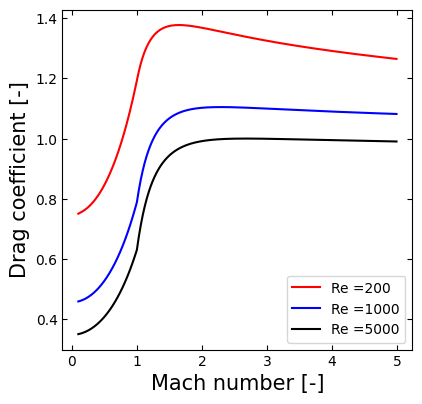

In [3]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
axNormal(axs)

colors=["red", "b", "black"]
Res = [200, 1000, 5000]
for iRe in np.arange(3):
    Re = Res[iRe]
    Ms = np.arange(0.1,5,0.01)
    Cds = Ms * 0
    i = 0
    for Mach in Ms:
        Cds[i] = SinghDrag(Mach, Re, 300)
        i += 1
    axs.plot(Ms, Cds, color = colors[iRe],label="Re =" + str(int(Re)))
axs.set_xlabel("Mach number [-]", size=15)
axs.set_ylabel("Drag coefficient [-]", size=15)

plt.legend()
plt.show()

## Brief example
* Fluid temperature is 300 K
* Fluid viscosity is calculated from [Sutherland's equation](https://resources.wolframcloud.com/FormulaRepository/resources/Sutherlands-Formula#:~:text=The%20dynamic%20viscosity%20equals%20the,the%20temperature%20to%20reference%20temperature.)
* Particle diameter is 10 $\rm{\mu}m$
* Fluid speed is equal to speed of sound
* Particle speed is 0

In [4]:
T_g = 300   # fluid temperature
rho_g = 1.2 # fluid density
mu_g = 1.81e-5 * np.power(T_g / 288.15, 1.5) * (288.15 + 110.4) / (T_g + 110.4) # fluid viscosity
c_g = np.sqrt(gamma * R / MW_g * T_g) # spped of sound
D_d = 10e-6 # particle diameter
rho_d = 1000    # particle density

u_g = c_g # fluid velocity (equal to speed of sound)
u_d = 0   # particle velocity
u = u_g - u_d   # relative velocity

Mach = u / c_g  # Mach number
Re_d = rho_g * u * D_d / mu_g   # Reynolds number

Cd = SinghDrag(Mach, Re_d, T_g)
F_d_singh = (np.pi / 8) * Cd * rho_g * u**2 * D_d**2

## Stokes number calculation with Singh's drag model

In [46]:
def Stokes(T_g,p,D_d,rho_d,L):
    rho_g=p/R/T_g*MW_g
    mu_g = 1.81e-5 * np.power(T_g / 288.15, 1.5) * (288.15 + 110.4) / (T_g + 110.4) # fluid viscosity
    c_g = np.sqrt(gamma * R / MW_g * T_g) # spped of sound

    Mach = 1  # Mach number
    Re_d = rho_g * c_g * D_d / mu_g   # Reynolds number

    Cd = SinghDrag(Mach, Re_d, T_g)
    F_d_singh = (np.pi / 8) * Cd * rho_g * c_g**2 * D_d**2
    V=np.pi*D_d**3/6.0
    m=V*rho_d
    Stk=c_g*c_g*m/F_d_singh/L
    
    return Stk


In [47]:
Stokes(300,1.013e5,0.5e-6,1000,0.36e-3)

0.38180079606736955